# Intro to Argovis' Grid API

Argovis offers a growing list of gridded products, indexed and downloadable through its API. In this notebook, we'll illustrate some basic operations and handling of this data.

## Setup

In addition to importing a few python packages, make sure to plug in your Argovis API key for `API_KEY` in the next cell. If you don't have a free Argovis API key yet, get one at https://argovis-keygen.colorado.edu/.

In [21]:
import requests, xarray, pandas, math, datetime
import numpy as np
from datetime import datetime, timedelta

API_KEY=''

## Downloading Gridded Data

Argovis offers gridded data at its `/grids` endpoint. Available query string parameters are:

 - `gridName` (mandatory, one of rgTempTotal, rgPsalTotal, ohc): name of gridded product to search.
 - `startDate` (mandatory, format YYYY-MM-DDTHH:MM:SSZ at GMT0): beginning of time window to query.
 - `endDate` (mandatory, format YYYY-MM-DDTHH:MM:SSZ at GMT0): end of time window to query.
 - `polygon` (mandatory, format [[lon0,lat0],[lon1,lat1],...,[lonN,latN],[lon0,lat0]]): geographical region to query.
 - `presRange` (optional, format minimum_pressure,maximum_pressure): pressure window to filter for.

As noted, `gridName`, `startDate`, `endDate` and `polygon` are all required for downloading gridded data, but we can get just the metadata record that describes some high-level information about each grid by providing only the `gridName` parameter:


In [22]:
params = {
  "gridName": 'rgTempTotal',
}

r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
print(r.json())

{'_id': 'rgTempTotal', 'units': 'degree celcius (ITS-90)', 'levels': [2.5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 182.5, 200, 220, 240, 260, 280, 300, 320, 340, 360, 380, 400, 420, 440, 462.5, 500, 550, 600, 650, 700, 750, 800, 850, 900, 950, 1000, 1050, 1100, 1150, 1200, 1250, 1300, 1350, 1412.5, 1500, 1600, 1700, 1800, 1900, 1975], 'date_added': '2022-04-27T23:07:27.943Z', 'lonrange': [-179.5, 179.5], 'latrange': [-64.5, 79.5], 'timerange': ['2004-01-15T00:00:00.000Z', '2018-12-15T00:00:00.000Z'], 'loncell': 1, 'latcell': 1}


We see information about the Roemmich-Gilson Argo climatology, like what pressure levels are present, what the minimum and maximum of latitude, longitude and time is in the grid, and soforth.

Let's try a simple request to download a piece of data from this climatology, a 10 degree box over the North Atlantic from the first quarter of 2012:

In [23]:
params = {
  "gridName": 'rgTempTotal',
  "startDate": '2012-01-01T00:00:00Z',
  "endDate": '2013-01-01T00:00:00Z',
  "polygon": '[[-66.621094,42.163403],[-71.367188,40.580585],[-74.003906,37.439974],[-75.058594,35.029996],[-79.453125,32.249974],[-80.15625,29.993002],[-78.75,23.725012],[-73.828125,21.289374],[-70.3125,20.797201],[-67.5,19.47695],[-64.160156,19.47695],[-66.621094,42.163403]]'
}

r = requests.get('https://argovis-api.colorado.edu/grids', params=params, headers={'x-argokey': API_KEY})
rgdata = r.json()

Like most Argovis API requests, you get a list of documents matching your query. Let's have a look at the first record in what the API returned to us:

In [24]:
rgdata[0]

{'_id': 'rgTempTotal',
 'units': 'degree celcius (ITS-90)',
 'levels': [2.5,
  10,
  20,
  30,
  40,
  50,
  60,
  70,
  80,
  90,
  100,
  110,
  120,
  130,
  140,
  150,
  160,
  170,
  182.5,
  200,
  220,
  240,
  260,
  280,
  300,
  320,
  340,
  360,
  380,
  400,
  420,
  440,
  462.5,
  500,
  550,
  600,
  650,
  700,
  750,
  800,
  850,
  900,
  950,
  1000,
  1050,
  1100,
  1150,
  1200,
  1250,
  1300,
  1350,
  1412.5,
  1500,
  1600,
  1700,
  1800,
  1900,
  1975],
 'date_added': '2022-04-27T23:07:27.943Z',
 'lonrange': [-179.5, 179.5],
 'latrange': [-64.5, 79.5],
 'timerange': ['2004-01-15T00:00:00.000Z', '2018-12-15T00:00:00.000Z'],
 'loncell': 1,
 'latcell': 1}

The first object in a request to `/grids` is always the appropriate *metadata record* for the grid, the same as what you got from `/grids?gridName=rgTempTotal` above. We automatically include it at the front of the full data requests as it is necessary for interpreting that data, as we'll see immediately below.

All the records returned by `/grids` after the first specify the actual data we wanted; let's have a look at one of them:

In [25]:
rgdata[1]

{'_id': '626497daaa7c85060718d8d8',
 'g': {'type': 'Point', 'coordinates': [-79.5, 27.5]},
 't': '2012-12-15T00:00:00.000Z',
 'd': [25.17,
  25.118999,
  24.969,
  24.871,
  24.780998,
  24.650002,
  24.457001,
  24.265999,
  24.104,
  23.916,
  23.689001,
  23.323,
  22.879,
  22.407,
  21.834999,
  21.218,
  20.618,
  20.139999,
  19.65,
  19.192999,
  18.775,
  18.451,
  18.105,
  17.839001,
  17.608999,
  17.403999,
  17.198999,
  17.026001,
  16.862,
  16.707001,
  16.552,
  16.431,
  16.181,
  15.571,
  14.417999,
  12.849,
  11.514999,
  10.294001,
  9.136,
  7.936,
  6.888,
  6.515,
  5.672,
  4.961,
  4.521,
  4.486,
  4.527,
  4.591,
  4.588,
  4.526,
  4.422,
  4.314,
  4.194,
  4.081,
  3.995,
  3.9,
  3.814,
  3.775]}

By default, Argovis returns gridded data in a *profile-like* structure: this record, located in space by its `g` key (for geolocation) and time by its `t` key, contains the grid points for all corresponding depths in its `d` (for data) key. To interpret the list of numbers, compare it entry-by-entry to the `levels` key in the metadata record; for example, the two records printed above indicate that the temperature at these coordinates and 10 dbar depth is 25.118999.

## Ingestion by xarray

Xarray is a familiar pythonic data structure; we can transform a raw API response to an xarray with a helper similar to the following.

In [26]:
def xargrid(grid):
    # given the json response <grid> of a request to /grids,
    # return an xarray object with coordinates time, lat, lon, depth, and measurement value.
    
    lat = []
    lon = []
    time = []
    pres = []
    meas = []
    for p in grid[1:]:
        for i, e in enumerate(p['d']):
            lon.append(p['g']['coordinates'][0])
            lat.append(p['g']['coordinates'][1])
            # convert a string to a date (zeros to check at the end of date)
            time.append(datetime.strptime(p['t'], '%Y-%m-%dT%H:%M:%S.%fZ'))
            meas.append(p['d'][i])
            pres.append(grid[0]['levels'][i])
            
    df = pandas.DataFrame({"latitude": lat, 
                           "longitude": lon, 
                           "time": time, 
                           "pressure": pres, 
                           "measurement": meas}).set_index(["latitude","longitude","time","pressure"])
    return df.to_xarray()
    
ds = xargrid(rgdata)

Now we can do all the usual xarray operations; lets see what the ranges of our coordinate variables are:

In [27]:
print('latitudes:',ds['latitude'].data)
print('longitudes:',ds['longitude'].data)
print('times:',ds['time'].data)
print('pressures:',ds['pressure'].data)

latitudes: [19.5 20.5 21.5 22.5 23.5 24.5 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5
 33.5 34.5 35.5 36.5 37.5 38.5 39.5 40.5]
longitudes: [-79.5 -78.5 -77.5 -76.5 -75.5 -74.5 -73.5 -72.5 -71.5 -70.5 -69.5 -68.5
 -67.5 -66.5 -65.5 -64.5]
times: ['2012-01-15T00:00:00.000000000' '2012-02-15T00:00:00.000000000'
 '2012-03-15T00:00:00.000000000' '2012-04-15T00:00:00.000000000'
 '2012-05-15T00:00:00.000000000' '2012-06-15T00:00:00.000000000'
 '2012-07-15T00:00:00.000000000' '2012-08-15T00:00:00.000000000'
 '2012-09-15T00:00:00.000000000' '2012-10-15T00:00:00.000000000'
 '2012-11-15T00:00:00.000000000' '2012-12-15T00:00:00.000000000']
pressures: [   2.5   10.    20.    30.    40.    50.    60.    70.    80.    90.
  100.   110.   120.   130.   140.   150.   160.   170.   182.5  200.
  220.   240.   260.   280.   300.   320.   340.   360.   380.   400.
  420.   440.   462.5  500.   550.   600.   650.   700.   750.   800.
  850.   900.   950.  1000.  1050.  1100.  1150.  1200.  1250.  1300.
 1350.

We can easily select a slice of this array at constant pressure and time, to produce a possibly more conventional, map-like grid representation, and plot it with xarray's built in plots:

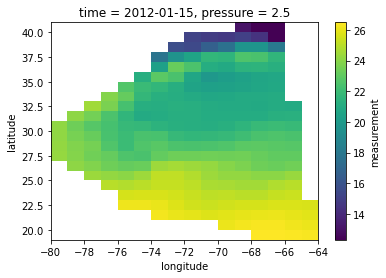

In [28]:
gridmap = ds.loc[{"time":'2012-01-15T00:00:00.000Z', "pressure":2.5}]
gridmap['measurement'].plot()

## Area-Weighted Means over a longitude/latitude region

A common operation when considering gridded data is to weight a mean by area of grid cells, which changes with latitude. A helper to do this with Argovis grid data could look like the following.

In [29]:
def areaweighted_region_mean(dxr):
    # given an xarray dataset <grid> for a given depth and time,
    # calculate the mean of the gridded data variable, weighted by grid cell area
    weights = np.cos(np.deg2rad(dxr.latitude))
    weights.name = "weights"
    dxr_weighted = dxr.weighted(weights)
    
    return dxr_weighted.mean(("longitude", "latitude"))

In [30]:
dxr_aw = areaweighted_region_mean(dxr=ds)
print(dxr_aw.loc[{"time":'2012-01-15T00:00:00.000Z', "pressure":2.5}])
dxr_aw

<xarray.Dataset>
Dimensions:      ()
Coordinates:
    time         datetime64[ns] 2012-01-15
    pressure     float64 2.5
Data variables:
    measurement  float64 22.74


<xarray.Dataset>
Dimensions:      (time: 12, pressure: 58)
Coordinates:
  * time         (time) datetime64[ns] 2012-01-15 2012-02-15 ... 2012-12-15
  * pressure     (pressure) float64 2.5 10.0 20.0 ... 1.8e+03 1.9e+03 1.975e+03
Data variables:
    measurement  (time, pressure) float64 22.74 22.74 22.75 ... 3.774 3.704

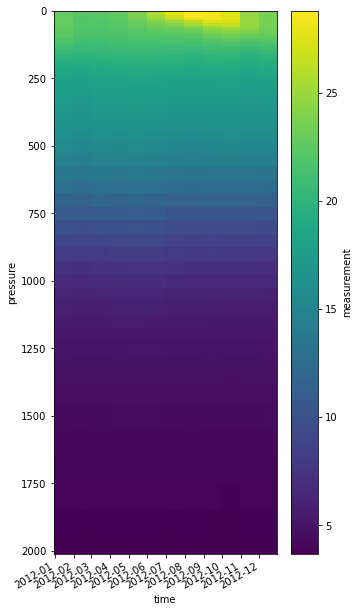

In [31]:
# Let's print the data after the spatial average over longitude and latitude
dxr_aw['measurement'].plot(y="pressure",yincrease=False,aspect=0.5, size=10)

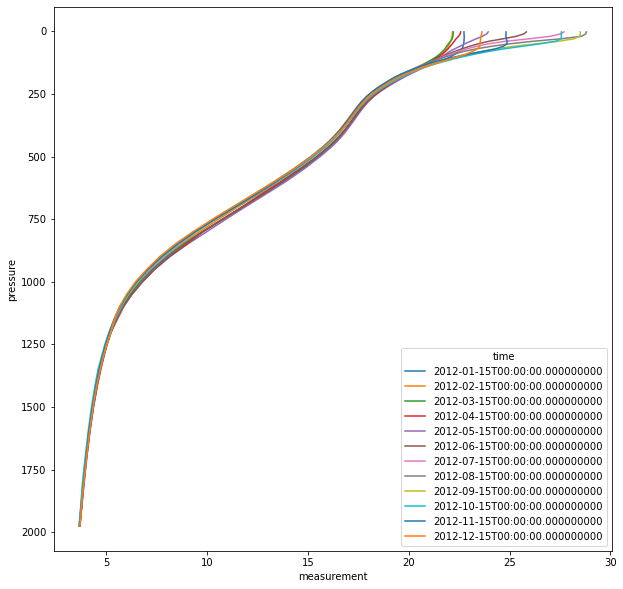

In [32]:
# Let's plot the data again, this time plotting one line per timestep
dxr_aw['measurement'].plot.line(y="pressure",yincrease=False,aspect=1, size=10)